## Marching Cubes with Laplacian Smoothing
(This Lab demands the package [PyMCubes](https://github.com/pmneila/PyMCubes) and [scikit-image](http://scikit-image.org))

In [1]:
import numpy as np
import mcubes
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

In [2]:
def vertices_to_side_length(T,V):
    def euc_distance(vv,uu):
        return np.sqrt(np.sum(np.square(vv-uu),axis=1))
    v0 = V[T[:,0],:]
    v1 = V[T[:,1],:]
    v2 = V[T[:,2],:]
    return np.vstack((euc_distance(v0,v1),euc_distance(v0,v2),euc_distance(v1,v2))).T

def cal_semiperimeter(T):
    return np.sum(T,axis=1)/2

# compute the area of each triangle mesh
def cal_area(T):
    sp = cal_semiperimeter(T)
    return np.sqrt(sp*(sp-T[:,0])*(sp-T[:,1])*(sp-T[:,2]))

# compute the inradius
def cal_inradius(T):
    return cal_area(T)/cal_semiperimeter(T)

# compute the circumradius
def cal_circumradius(T):
    return T[:,0]*T[:,1]*T[:,2]/4/cal_semiperimeter(T)/cal_inradius(T)

def cal_ratio(T):
    return 2*cal_inradius(T)/cal_circumradius(T)

def draw_histogram(T,V,title):
    tsl = vertices_to_side_length(T,V)
    ta = cal_area(tsl)
    tr = cal_ratio(tsl)
    figure = plt.figure()
    plt.title(title)
    plt.hist(tr,50,(0,1))
    plt.show()
    print("Area of the surface: {}".format(np.sum(ta)))
    print("Average ratio q=2r/R: {}".format(np.mean(tr)))
    
def averaging_step(vertices,lam,mu,mu_step=True):
    # Computing the Laplacian smoothing 
    n = vertices.shape[0]
    W = np.zeros((n,n))

    # LUIS'S METHOD (simplest computationally, maybe not most intuitive) #
    # build L grid ((i, j) is weighted = 1 if a triangle has a corner there)
    W[triangles[:,0],triangles[:,1]]=1
    W[triangles[:,0],triangles[:,2]]=1
    W[triangles[:,1],triangles[:,0]]=1
    W[triangles[:,1],triangles[:,2]]=1
    W[triangles[:,2],triangles[:,0]]=1
    W[triangles[:,2],triangles[:,1]]=1

    # compute the diagonal matrix, contribution ration from each vert (1/N bit from equation)
    # smoothed vertices will be D dot (L dot vertices)
    W /= np.sum(W,axis=1,keepdims=True)
    np.fill_diagonal(W,-1)
    
    smoothed_vertices = vertices + lam*W.dot(vertices)
    if mu_step:
        smoothed_vertices = smoothed_vertices + mu*W.dot(smoothed_vertices)
    return smoothed_vertices

In [17]:
def fun(x, y, z):
    # you can make this whatever you'd like
    return np.square(x)+np.square(y)+np.square(z)-2
#     return np.cos(x) + np.cos(y) + np.cos(z)
#     return z

# grid size
n = 30j   # complex number bc mgrid receives complex as input

# create 3D grid
X, Y, Z = np.pi*np.mgrid[-1:1:n,-1:1:n,-1:1:n]

# defining a function in the grid
f = fun(X,Y,Z)

#computing the isosurface 0
vertices, triangles = mcubes.marching_cubes(f, 0)


# mcubes do not return a consistent mesh
# vertices are repeated in the list of vertices
# print(vertices[np.where(vertices[:,0]==0.)])

# use scikit-image's marching cubes ignore those repeat vertices
from skimage.measure import marching_cubes_lewiner as mc_lewiner

vertices, triangles, normals, values = mc_lewiner(f, 0)

print(vertices.shape)
print(triangles.shape)

vertices_ori = vertices.copy()
# vertices+=np.random.randn(*vertices.shape)/2
vertices[vertices[:,0]>15]+=np.random.randn(*vertices[vertices[:,0]>15].shape)/2

(744, 3)
(1484, 3)


0.5 -0.5002501250625312


<IPython.core.display.Javascript object>


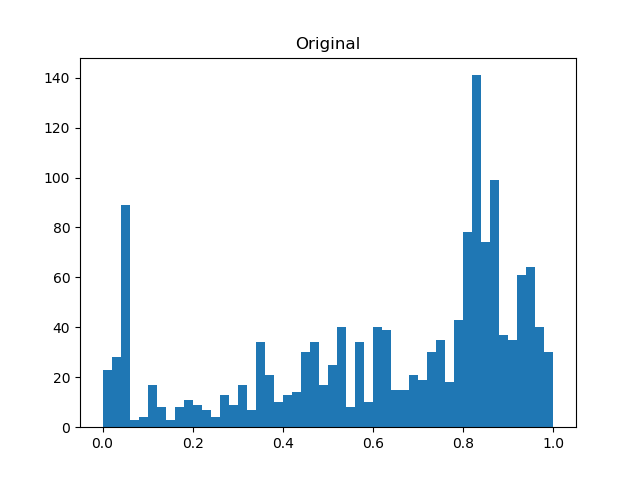

Area of the surface: 784.1385498046875
Average ratio q=2r/R: 0.6332440972328186


<IPython.core.display.Javascript object>


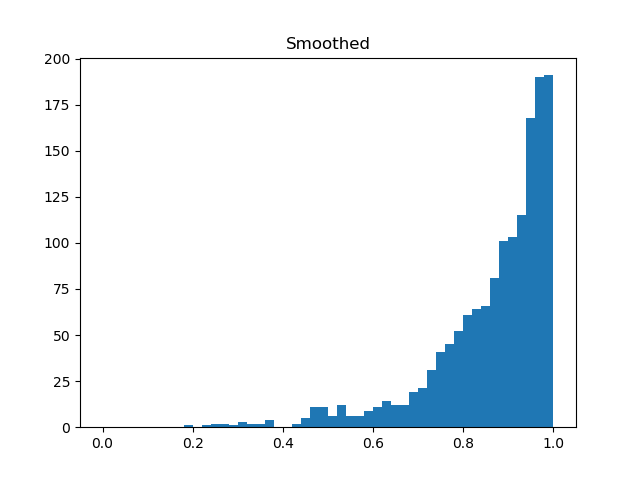

Area of the surface: 533.1962727388513
Average ratio q=2r/R: 0.863836512323919


<IPython.core.display.Javascript object>


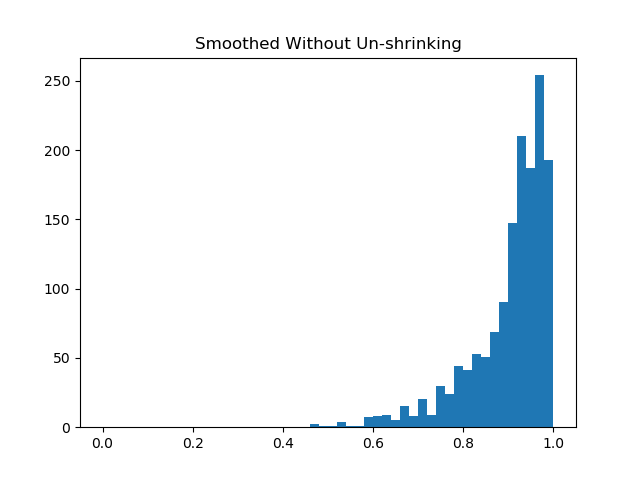

Area of the surface: 526.5929275452964
Average ratio q=2r/R: 0.9031749479819099


In [24]:
kpb = 0.001
lam = 0.5
mu = 1/(kpb-1/lam)
print(lam, mu)

smoothed_vertices = vertices
smoothed_vertices_without_mu = vertices
for i in range(10):
    smoothed_vertices = averaging_step(smoothed_vertices,lam,mu)
    
for i in range(50):
    smoothed_vertices_without_mu = averaging_step(smoothed_vertices_without_mu,lam,mu)

draw_histogram(triangles,vertices,"Original")    
draw_histogram(triangles,smoothed_vertices,"Smoothed")
draw_histogram(triangles,smoothed_vertices_without_mu,"Smoothed Without Un-shrinking")


<IPython.core.display.Javascript object>


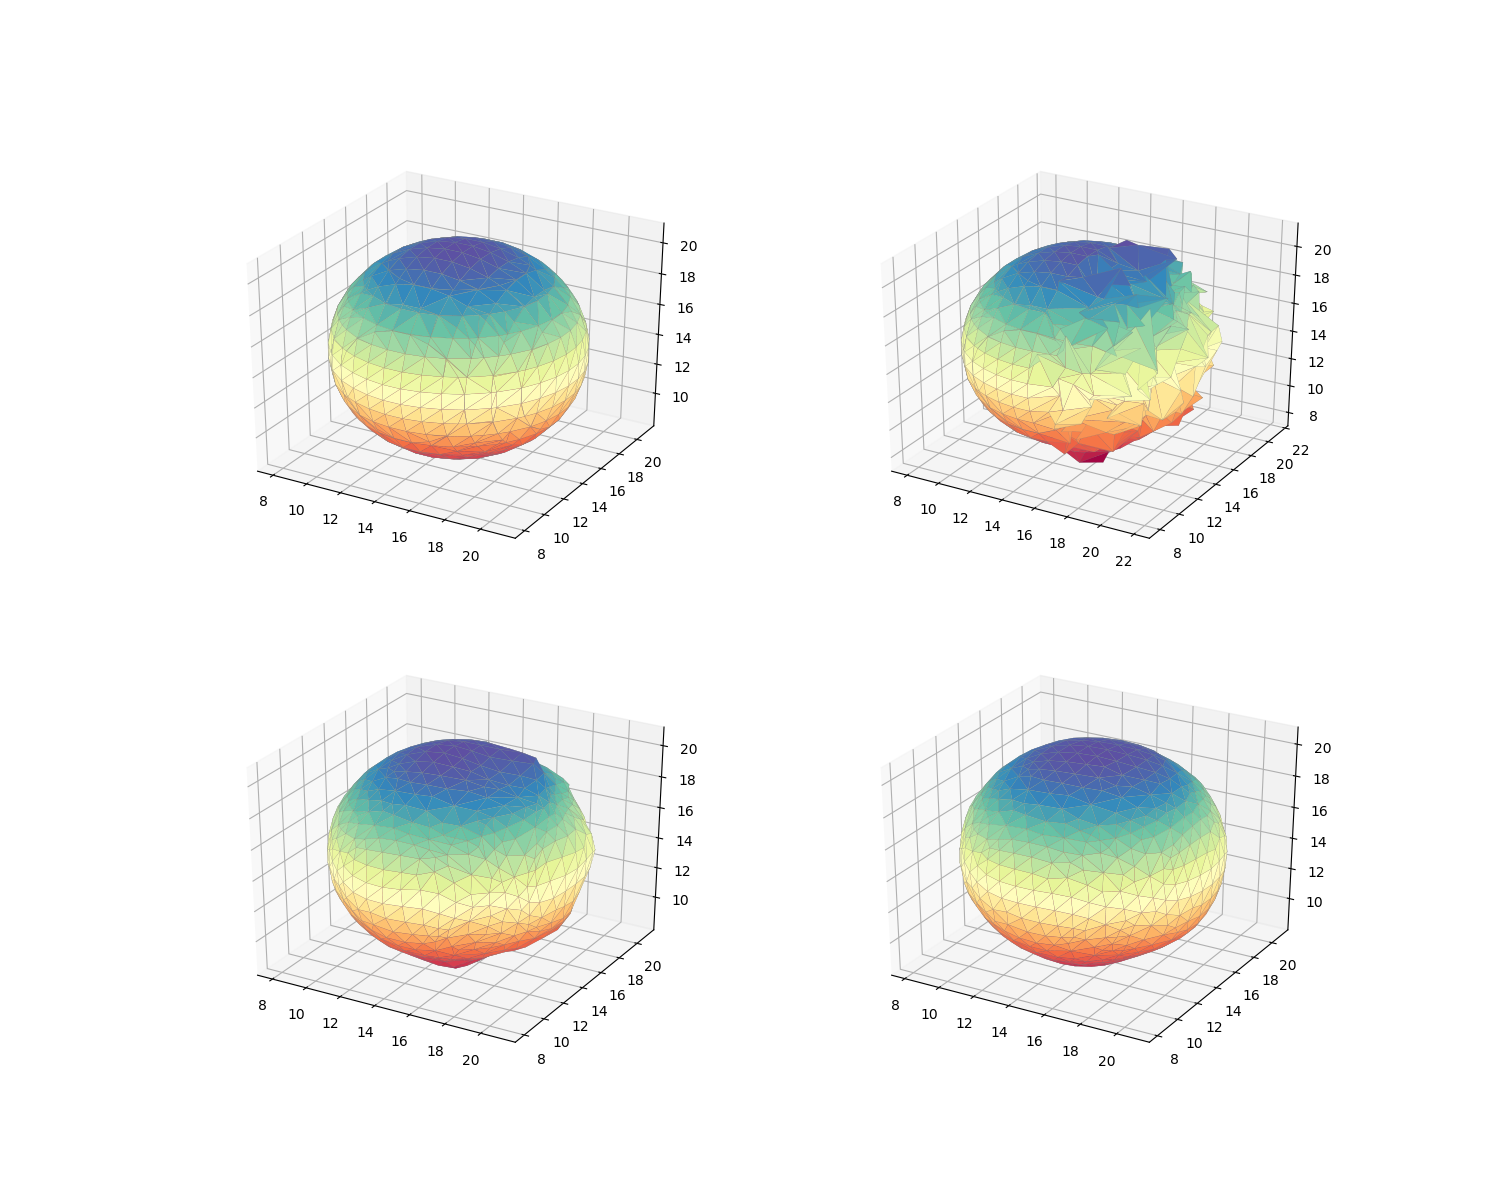

In [25]:
fig = plt.figure(figsize=(15,12))
ax1 = fig.add_subplot(221, projection='3d')
ax1.plot_trisurf(vertices_ori[:, 0], vertices_ori[:,1], vertices_ori[:, 2], triangles = triangles,
                cmap='Spectral',edgecolor='Gray',lw=0.1)



ax2 = fig.add_subplot(222, projection='3d')
ax2.plot_trisurf(vertices[:, 0], vertices[:,1], vertices[:, 2], triangles = triangles,
                cmap='Spectral',edgecolor='Gray',lw=0.1)

ax3 = fig.add_subplot(223, projection='3d')
ax3.plot_trisurf(smoothed_vertices[:, 0], smoothed_vertices[:,1], smoothed_vertices[:, 2], triangles = triangles,
                cmap='Spectral',edgecolor='Gray',lw=0.1)

ax4 = fig.add_subplot(224, projection='3d')
ax4.plot_trisurf(smoothed_vertices_without_mu[:, 0], smoothed_vertices_without_mu[:,1], smoothed_vertices_without_mu[:, 2], triangles = triangles,
                cmap='Spectral',edgecolor='Gray',lw=0.1)
plt.show()